In [32]:
from datasets import load_dataset
import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2


# Unet architecture

We will try to first build our model based on the Unet architecture because from our personal research, this architecture seems to be commonly used for image segmentation.

In [33]:
# Set random seed for reproducibility
torch.manual_seed(42)


image_train_dataset = load_dataset(
'keremberke/satellite-building-segmentation',
split='train', name='mini'
).to_pandas()
image_train_dataset.head()

image_id                                              image  width  height  \
0      1517  {'bytes': None, 'path': 'C:\Users\princ\.cache...    500     500   
1      1030  {'bytes': None, 'path': 'C:\Users\princ\.cache...    500     500   
2      1217  {'bytes': None, 'path': 'C:\Users\princ\.cache...    500     500   

                                             objects  
0  {'id': [20602, 20603, 20604, 20605, 20606], 'a...  
1  {'id': [14034, 14035, 14036, 14037, 14038, 140...  
2  {'id': [16678, 16679, 16680, 16681, 16682, 166...

In [34]:
# Classes needed for processing data (personal dataSet class for Torch)

class MyDataset(torch.utils.data.Dataset):

    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        im = self.dataframe.iloc[index]
        image_path = im['image']['path']
        img = Image.open(image_path).convert('RGB')


        segmentation = self.parse_segmentation(im['objects'], img.size)
        #print(segmentation)
        # Transforms segmentation from numpy array to PIL image
        pil_segmentation = Image.fromarray(segmentation)
        if self.transform is not None:
            real_img = self.transform(img)
            real_segmentation = self.transform(pil_segmentation)

        #print(im['image'])
        # with index = 1 return the path of the first image of dataset

        #print(im['objects'])
        # Full dataframe, not sure what to use it for right now (contains id_objects [building or not, etc...])
        # See next markdown cell to see typical representation
        return {'image' : real_img, 'segmentation': real_segmentation }
    

    def parse_segmentation(self, object, size):
        
        segmentation_mask = np.zeros(size, dtype=np.uint8)

        for obj in object['segmentation']:
            for polygon in obj:
                polygon = np.array(polygon, dtype=np.int32)
                polygon = polygon.reshape((-1, 2))
                cv2.fillPoly(segmentation_mask, [polygon], 1)

        return segmentation_mask

## Example data contained in 'objects' field for one column

```{'id': array([14034, 14035, 14036, 14037, 14038, 14039, 14040, 14041, 14042],
      dtype=int64), 'area': array([31164, 29682,  6802,  6863, 17415, 45449,  7452,  7105,  4062],
      dtype=int64), 'bbox': array([array([236.  , 350.  , 207.36, 150.29], dtype=float32),
       array([  0.  , 133.  , 191.28, 155.18], dtype=float32),
       array([429.  ,  78.  ,  70.98,  95.83], dtype=float32),
       array([432.  , 268.  ,  67.75, 101.3 ], dtype=float32),
       array([295.  , 135.  , 120.48, 144.55], dtype=float32),
       array([ 46.  , 221.  , 227.5 , 199.78], dtype=float32),
       array([341.  ,   0.  ,  87.23,  85.44], dtype=float32),
       array([198.  ,  86.  ,  87.67,  81.05], dtype=float32),
       array([447.  , 362.  ,  52.53,  77.33], dtype=float32)],
      dtype=object), 'segmentation': array([array([array([377.6 , 500.  , 376.23, 490.68, 371.24, 485.31, 443.08, 432.72,
                     349.77, 349.71, 265.06, 391.88, 328.69, 446.58, 235.72, 500.  ,
                     377.6 , 500.  ], dtype=float32)                                ],
             dtype=object)                                                            ,
       array([array([9.5200e+00, 2.8832e+02, 2.0440e+01, 2.7899e+02, 1.7660e+01,
                     2.7638e+02, 2.1910e+01, 2.7333e+02, 2.4110e+01, 2.7469e+02,
                     4.7520e+01, 2.5993e+02, 5.0120e+01, 2.6417e+02, 5.8830e+01,
                     2.5761e+02, 6.0760e+01, 2.6061e+02, 8.6430e+01, 2.4149e+02,
                     8.9540e+01, 2.4545e+02, 1.0594e+02, 2.3595e+02, 1.0181e+02,
                     2.3103e+02, 1.2749e+02, 2.1848e+02, 1.3099e+02, 2.2504e+02,
                     1.4490e+02, 2.1520e+02, 1.4903e+02, 2.2068e+02, 1.8720e+02,
                     1.9885e+02, 1.9128e+02, 1.8686e+02, 1.4886e+02, 1.3314e+02,
                     1.3000e-01, 2.1344e+02, 0.0000e+00, 2.7890e+02, 9.5200e+00,
                     2.8832e+02], dtype=float32)                                ],
             dtype=object)                                                        ,
       array([array([500.  ,  78.07, 434.99, 109.69, 429.02, 123.13, 461.76, 170.73,
                     468.8 , 166.8 , 474.4 , 173.9 , 481.1 , 167.8 , 492.87, 165.13,
                     500.  , 170.85, 500.  ,  78.07], dtype=float32)                ],
             dtype=object)                                                            ,
       array([array([500.  , 267.6 , 487.89, 275.17, 490.48, 278.11, 478.73, 286.92,
                     478.56, 294.01, 473.89, 292.8 , 465.77, 297.81, 464.21, 295.39,
                     453.67, 301.26, 446.6 , 304.2 , 446.3 , 309.5 , 442.7 , 313.3 ,
                     439.85, 310.94, 432.25, 315.61, 445.5 , 331.4 , 470.6 , 357.2 ,
                     473.72, 355.  , 485.8 , 368.9 , 500.  , 361.41, 500.  , 267.6 ],
                    dtype=float32)                                                   ],
             dtype=object)                                                             ,
       array([array([331.33, 147.38, 311.6 , 158.  , 321.82, 172.66, 316.06, 176.28,
                     341.73, 215.4 , 296.93, 243.18, 295.47, 249.16, 321.74, 279.38,
                     381.33, 244.86, 364.52, 222.67, 411.22, 197.17, 415.95, 185.73,
                     379.87, 134.83, 357.47, 142.74, 345.3 , 147.77, 331.33, 147.38],
                    dtype=float32)                                                   ],
             dtype=object)                                                             ,
       array([array([ 46.2 , 331.58,  86.33, 380.87, 102.47, 369.44, 143.32, 420.93,
                     193.  , 390.2 , 151.76, 342.42, 197.83, 314.3 , 188.6 , 302.5 ,
                     195.5 , 297.8 , 203.6 , 307.43, 208.  , 304.8 , 216.6 , 314.66,
                     212.67, 317.76, 223.  , 330.25, 234.66, 322.75, 235.88, 324.87,
                     273.7 , 302.76, 270.44, 285.87, 226.3 , 221.15, 161.26, 260.39,
                      59.79, 316.27,  46.2 , 331.58], dtype=float32)                ],
             dtype=object)                                                            ,
       array([array([373.74,  81.64, 378.22,  78.53, 382.2 ,  85.44, 399.47,  72.29,
                     402.23,  76.63, 415.38,  68.85, 411.76,  62.11, 426.95,  55.02,
                     428.3 ,  47.9 , 391.38,   0.  , 341.07,  25.5 , 370.99,  61.08,
                     364.39,  64.69, 373.74,  81.64], dtype=float32)                ],
             dtype=object)                                                            ,
       array([array([221.95, 159.74, 224.89, 158.36, 232.84, 166.83, 241.65, 161.3 ,
                     244.41, 165.1 , 250.98, 160.09, 254.61, 165.79, 280.18, 148.85,
                     275.86, 143.84, 285.37, 136.59, 253.57,  96.67, 239.06,  85.78,
                     231.97,  91.31, 228.86,  86.13, 209.51,  95.11, 209.3 , 108.4 ,
                     203.6 , 113.  , 206.5 , 115.9 , 197.7 , 121.3 , 207.43, 132.09,
                     206.92, 144.53, 221.95, 159.74], dtype=float32)                ],
             dtype=object)                                                            ,
       array([array([500.  , 362.2 , 448.67, 389.52, 447.47, 401.76, 458.22, 410.72,
                     455.54, 422.96, 472.26, 433.71, 500.  , 439.53, 500.  , 384.03,
                     500.  , 362.2 ], dtype=float32)                                ],
             dtype=object)                                                            ],
      dtype=object), 'category': array([0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)}

In [35]:
# Classes needed for the model definition

class layer_conv2(nn.Module):
    # Give as parameter the input and output channel
    def __init__(self, input_channel, output_channel):
        super(layer_conv2, self).__init__()
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=input_channel, out_channels=output_channel, kernel_size=3, padding=1),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(),
            nn.Conv2d(in_channels=output_channel, out_channels=output_channel, kernel_size=3, padding=1),
            nn.BatchNorm2d(output_channel),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.conv2(x)
        return x
    

class begin_model(nn.Module):
    # Give as parameter the input and output channel
    def __init__(self, input_channel, output_channel):
        super(begin_model, self).__init__()
        self.first_step = layer_conv2(input_channel, output_channel)

    def forward(self, x):
        x = self.first_step(x)
        return x
    
class end_model(nn.Module):
    # Give as parameter the input and output channel
    def __init__(self, input_channel, output_channel):
        super(end_model, self).__init__()
        self.final_step = nn.Conv2d(in_channels=input_channel, out_channels=output_channel, kernel_size=1)

    def forward(self, x):
        x = self.final_step(x)
        return x
    

# Classes necessary for 'creating' the U shape of the architecture
    
class down(nn.Module):

    def __init__(self, input_channel, output_channel):
        super(down, self).__init__()
        self.md = nn.Sequential(
            nn.MaxPool2d(2),
            layer_conv2(input_channel, output_channel)
        )

    def forward(self, x):
        x = self.md(x)
        return x

class up(nn.Module):

    def __init__(self, input_channel, output_channel, bilinear=True):
        super(up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(input_channel, output_channel, 2, stride=2)
        self.conv = layer_conv2(input_channel//2, output_channel)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.up(x)
        x = self.conv(x)
        x = self.dropout(x)
        return x

class complete_model(nn.Module):
    # We give the number of classes expected and the number of channels
    def __init__(self, num_chan, num_class):
        super(complete_model, self).__init__()
        self.debut = begin_model(num_chan, output_channel=64)
        self.d1 = down(input_channel=64, output_channel=128)
        self.d2 = down(input_channel=128, output_channel=256)
        self.u1 = up(input_channel=256, output_channel=128,bilinear=False)
        self.u2 = up(input_channel=128, output_channel=64,bilinear=False)
        self.fin = end_model(input_channel=64, output_channel=num_class)

    def forward(self, x):
        x = self.debut(x)
        x = self.d1(x)
        x = self.d2(x)
        x = self.u1(x)
        x = self.u2(x)
        x = self.fin(x)
        return torch.sigmoid(x)


In [36]:
# Setting up the dataframe
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((512, 512)),
    torchvision.transforms.ToTensor(),
])

train_df = MyDataset(image_train_dataset, transform)

train_df[1]

{'image': tensor([[[0.7686, 0.7608, 0.7686,  ..., 0.5922, 0.6196, 0.6863],
          [0.7686, 0.7725, 0.7843,  ..., 0.5804, 0.5647, 0.5922],
          [0.7647, 0.7765, 0.7882,  ..., 0.6275, 0.5961, 0.6039],
          ...,
          [0.6980, 0.6863, 0.6863,  ..., 0.4510, 0.4471, 0.4392],
          [0.6941, 0.6863, 0.6863,  ..., 0.4549, 0.4510, 0.4471],
          [0.6784, 0.6706, 0.6784,  ..., 0.4627, 0.4588, 0.4510]],
 
         [[0.6471, 0.6392, 0.6471,  ..., 0.5451, 0.5725, 0.6392],
          [0.6471, 0.6510, 0.6627,  ..., 0.5333, 0.5176, 0.5451],
          [0.6431, 0.6549, 0.6667,  ..., 0.5804, 0.5490, 0.5569],
          ...,
          [0.6314, 0.6196, 0.6196,  ..., 0.3843, 0.3804, 0.3725],
          [0.6275, 0.6196, 0.6196,  ..., 0.3882, 0.3843, 0.3804],
          [0.6118, 0.6039, 0.6118,  ..., 0.3961, 0.3922, 0.3843]],
 
         [[0.5255, 0.5176, 0.5255,  ..., 0.4902, 0.5176, 0.5843],
          [0.5255, 0.5294, 0.5412,  ..., 0.4784, 0.4627, 0.4902],
          [0.5216, 0.5333, 0.54

In [37]:
%pip install -q -U segmentation-models-pytorch
import segmentation_models_pytorch as smp
# Looking only for buildings first so only two classes (building, not building)
# channels = 3 because RGB colors 
#model = complete_model(num_chan=3, num_class=1)

model = smp.Unet(
    encoder_name='resnet50',
    encoder_weights='imagenet',
    classes=1,
    activation='sigmoid'
)
# Using Adam as optimizer because the TPs did so
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Loss function with Binary Cross-Entropy because two classes at first (building, not building)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss


[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [38]:
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [39]:
def print_images(x):
    n = 1
    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(x[i].cpu().detach().numpy().reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

Epoch 1/5: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]

Image de base :


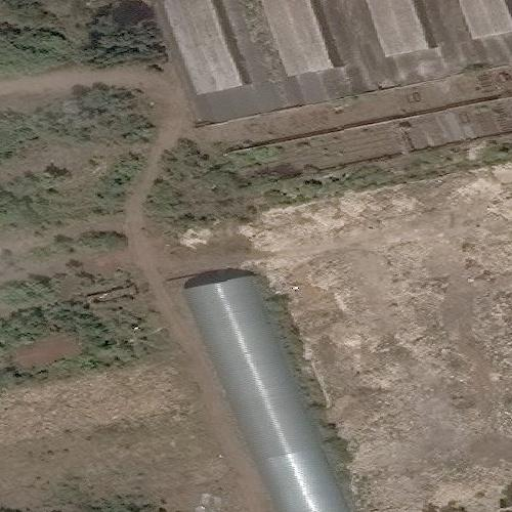

Segmentation calculée :


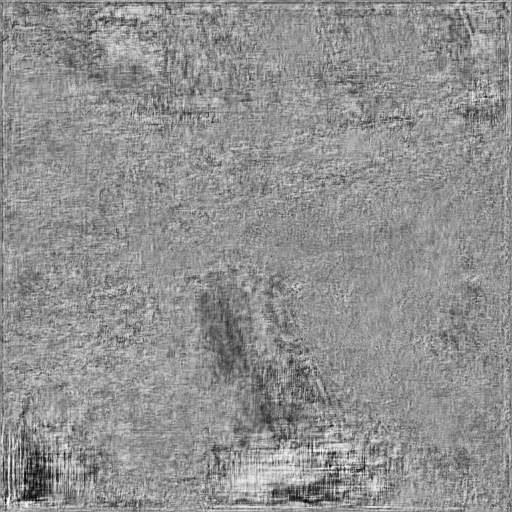

Epoch [1/5], Loss: 0.9777


Epoch 2/5: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]

Image de base :


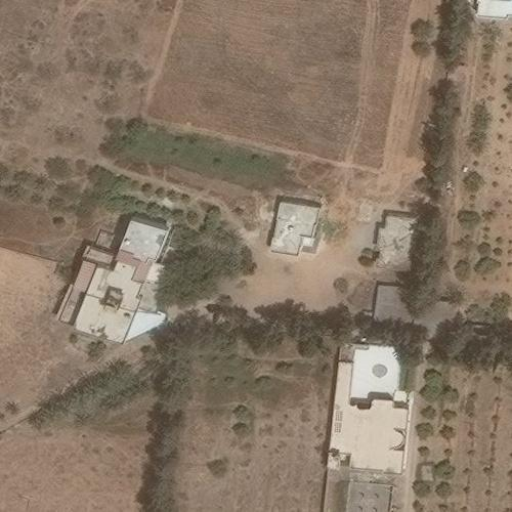

Segmentation calculée :


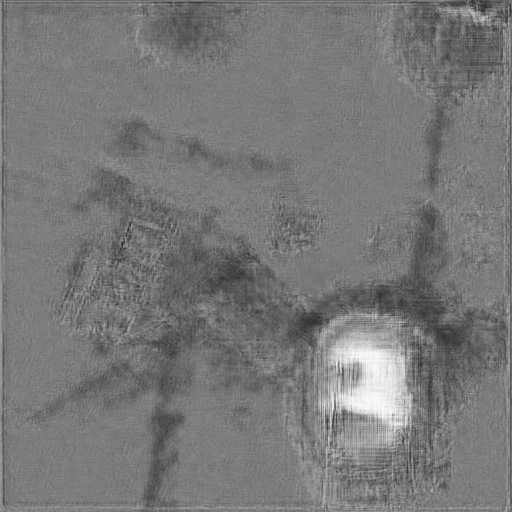

Epoch [2/5], Loss: 0.7049


Epoch 3/5: 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]

Image de base :


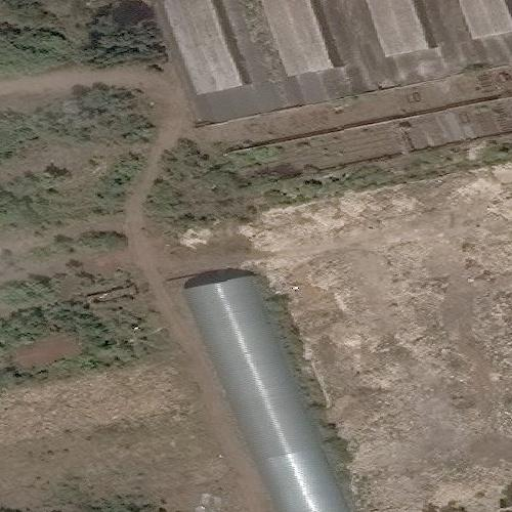

Segmentation calculée :


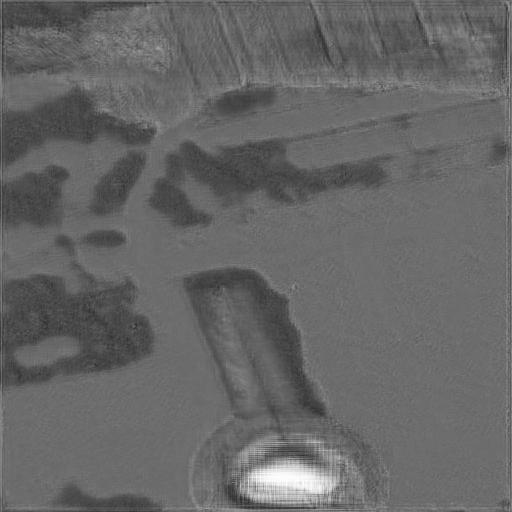

Epoch [3/5], Loss: 0.5648


Epoch 4/5: 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

Image de base :


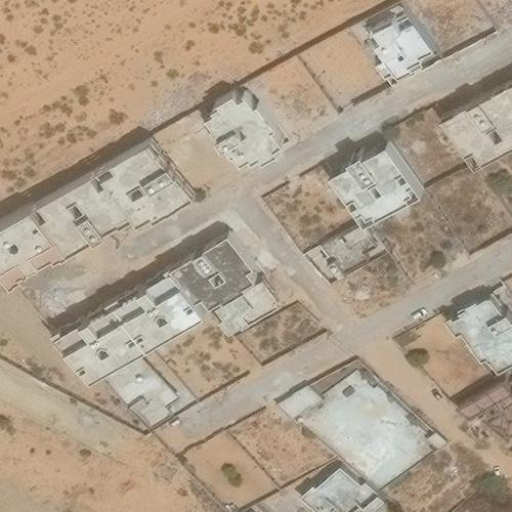

Segmentation calculée :


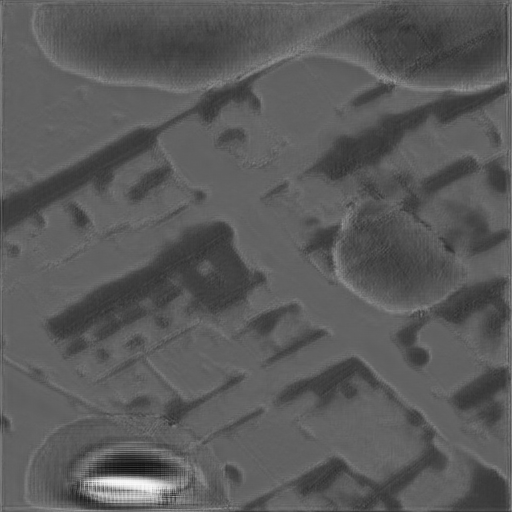

Epoch [4/5], Loss: 0.4734


Epoch 5/5: 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

Image de base :


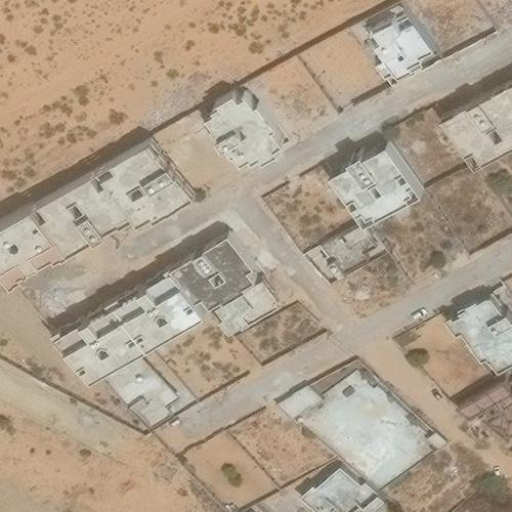

Segmentation calculée :


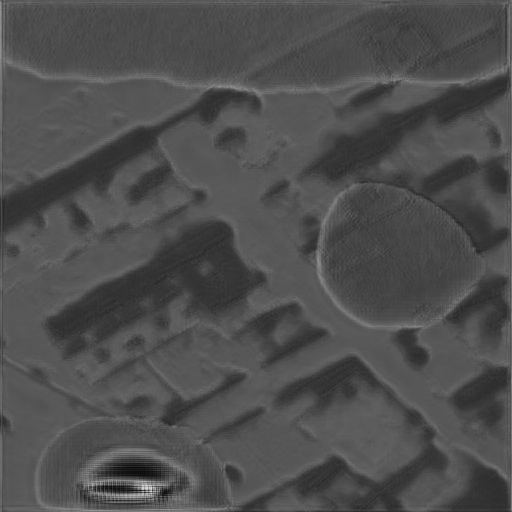

Epoch [5/5], Loss: 0.3982


In [40]:
from IPython.display import display

# training loop
train_loader = torch.utils.data.DataLoader(train_df, batch_size=1, shuffle=True)


epochs = 5
for epoch in range(epochs):   
    model.train()
    acc_for_avergage_loss = 0.0
    for batch in tqdm.tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
        input = batch["image"]
        target = batch["segmentation"]
        optimizer.zero_grad()
        outputs = model(input)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
    
        acc_for_avergage_loss += loss.item()

    # Print the loss at the end of each epoch
    average_loss = acc_for_avergage_loss / len(train_loader)
    print("Image de base :")
    display(torchvision.transforms.ToPILImage()(input[0]).convert('RGB'))
    # print_images(input)
    print("Segmentation calculée :")
    display(torchvision.transforms.ToPILImage()(outputs[0]).convert('RGB'))
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, epochs, average_loss))